In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [13]:
data = pd.read_csv("Loan_Default.csv")
print(data.shape)
data.head()

(148670, 34)


,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,Neg_ammortization,interest_only,lump_sum_payment,property_value,construction_type,occupancy_type,Secured_by,total_units,income,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,116500,NaN,NaN,NaN,360.0,not_neg,not_int,not_lpsm,118000.0,sb,pr,home,1U,1740.0,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,206500,NaN,NaN,NaN,360.0,not_neg,not_int,lpsm,NaN,sb,pr,home,1U,4980.0,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,406500,4.56,0.2000,595.0,360.0,neg_amm,not_int,not_lpsm,508000.0,sb,pr,home,1U,9480.0,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,456500,4.25,0.6810,NaN,360.0,not_neg,not_int,not_lpsm,658000.0,sb,pr,home,1U,11880.0,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,696500,4.00,0.3042,0.0,360.0,not_neg,not_int,not_lpsm,758000.0,sb,pr,home,1U,10440.0,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


### Data processing

In [14]:
# Check NA values
data.isna().sum()

ID                               0
year                             0
loan_limit                    3344
Gender                           0
approv_in_adv                  908
loan_type                        0
loan_purpose                   134
Credit_Worthiness                0
open_credit                      0
business_or_commercial           0
loan_amount                      0
rate_of_interest             36439
Interest_rate_spread         36639
Upfront_charges              39642
term                            41
Neg_ammortization              121
interest_only                    0
lump_sum_payment                 0
property_value               15098
construction_type                0
occupancy_type                   0
Secured_by                       0
total_units                      0
income                        9150
credit_type                      0
Credit_Score                     0
co-applicant_credit_type         0
age                            200
submission_of_applic

For the following columns, NA values can be filled with 0
- rate_of_interest
- interest_rate_spread
- upfront_charges
- term
- property_value
- income
- LTV

Will drop dtir1, as we do not have any information regarding what this column means

In [15]:
fill_w_0 = ["rate_of_interest", "Interest_rate_spread", "Upfront_charges", "term", "property_value", "income", "LTV"]

for column in fill_w_0:
    data[column] = data[column].fillna(0)


data.isna().sum()

ID                               0
year                             0
loan_limit                    3344
Gender                           0
approv_in_adv                  908
loan_type                        0
loan_purpose                   134
Credit_Worthiness                0
open_credit                      0
business_or_commercial           0
loan_amount                      0
rate_of_interest                 0
Interest_rate_spread             0
Upfront_charges                  0
term                             0
Neg_ammortization              121
interest_only                    0
lump_sum_payment                 0
property_value                   0
construction_type                0
occupancy_type                   0
Secured_by                       0
total_units                      0
income                           0
credit_type                      0
Credit_Score                     0
co-applicant_credit_type         0
age                            200
submission_of_applic

For the remaining NA values, we replace with the most common value for that column

In [16]:
fill_w_mean = ["loan_limit", "approv_in_adv", "loan_purpose", "Neg_ammortization", "age", "submission_of_application"]
for column in fill_w_mean:
    most_common = data[column].value_counts().idxmax()

    data[column] = data[column].fillna(most_common)

In [17]:
data_no_na = data.drop(columns = "dtir1")
data_no_na.isna().sum().sum()

0

Identify the labels in the target column (Status)

In [18]:
data_no_na["Status"].value_counts()

0    112031
1     36639
Name: Status, dtype: int64

Default loans are usually occurs much lesser than no default loans. We can see that Status = 1 has much lower occurrence than Status = 0, hence 1 represent default, 0 represents no default

### Data Exploration

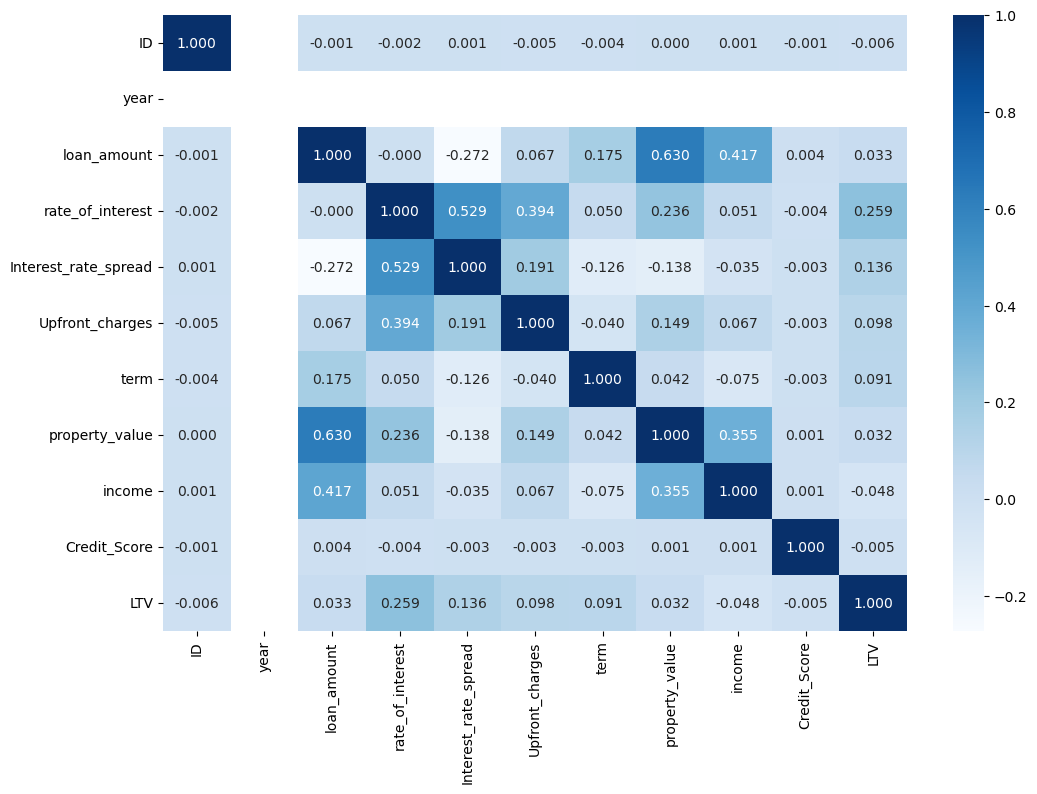

In [19]:
# Look at correlation between columns, drop highly correlated features
numeric_features = data_no_na.drop(columns = "Status").select_dtypes(exclude = object)
corr_mat = numeric_features.corr()

plt.figure(figsize = (12, 8))
sns.heatmap(corr_mat, cmap = "Blues", annot = True, fmt = ".3f")
plt.show()

The largest correlation we see occurs between property_value and loan_amount, which is 0.630. \
This correlation is high, but not enough to justify dropping a column. Hence, no columns will be dropped

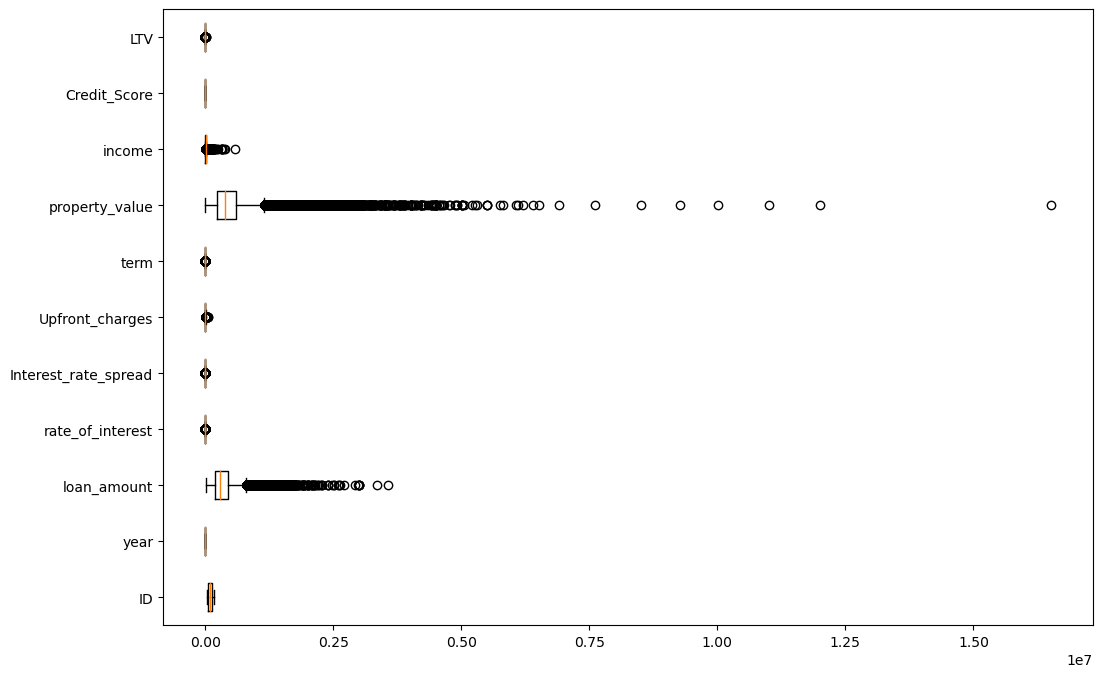

In [20]:
# Look at boxplot of numeric features

boxplot_data = []
for column in numeric_features.columns:
    boxplot_data.append(numeric_features[column].tolist())

plt.figure(figsize = (12, 8))
plt.boxplot(boxplot_data, labels = numeric_features.columns, vert = False)
plt.show()

Large number of outliers in property_value and loan_amount. Might want to remove outliers in these columns if model performance is poor

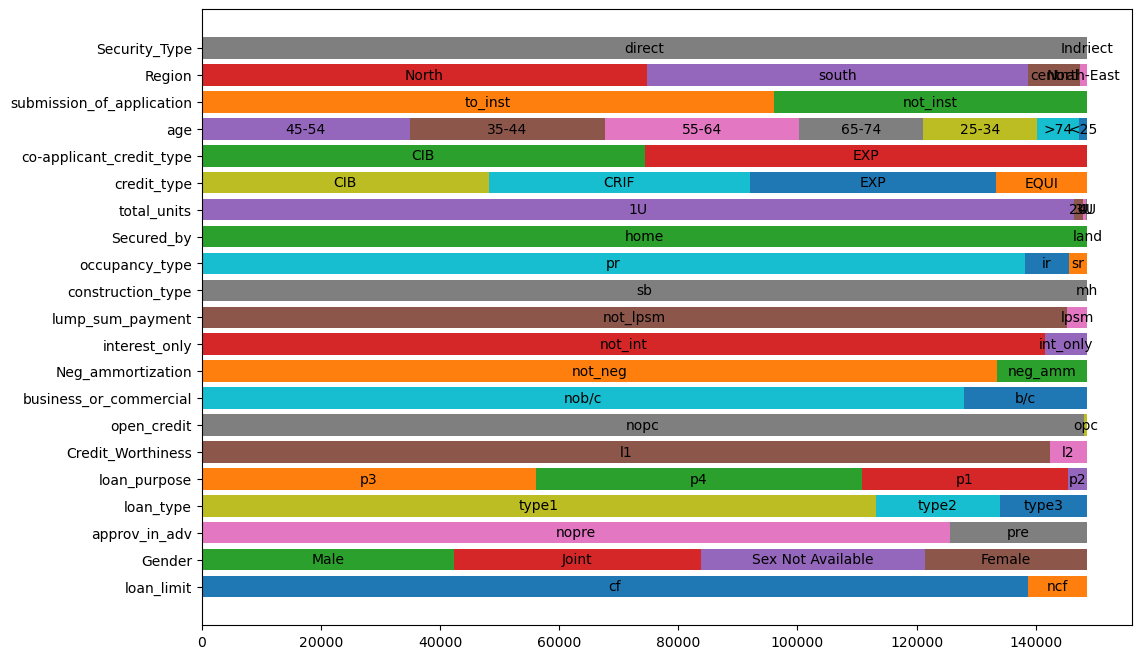

In [21]:
# Plot the distribution of labels in categoric column using stacked barcharts
categoric_features = data_no_na.drop(columns = "Status").select_dtypes(include = object)

plt.figure(figsize = (12, 8))
for i, column in enumerate(categoric_features.columns):
    label_counts = data_no_na[column].value_counts()

    total = 0
    for label, value in label_counts.items():
        plt.annotate(label, (total + value // 2, i), ha = "center", va = "center")
        plt.barh(y = i, width = value, left = total)
        total += value


plt.yticks(range(len(categoric_features.columns)), labels = categoric_features.columns)
plt.show()

Most categorical columns have a large imbalance in the labels of the column.
One hot encoding should work for most of the columns, as they have a small number of labels. 

For age, we will use label encoding

In [22]:
model_data = data_no_na.drop(columns = ["ID", "year"])

one_hot_encode_columns = [column for column in categoric_features.columns if column != "age"]
model_data = pd.get_dummies(model_data, columns = one_hot_encode_columns)

age_map = {
    "<25": 1,
    "25-34": 2,
    "35-44": 3,
    "45-54": 4,
    "55-64": 5,
    "65-74": 6,
    ">74": 7
}
model_data["age"] = model_data["age"].replace(age_map)
model_data.head()

,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,age,LTV,Status,loan_limit_cf,loan_limit_ncf,Gender_Female,Gender_Joint,Gender_Male,Gender_Sex Not Available,approv_in_adv_nopre,approv_in_adv_pre,loan_type_type1,loan_type_type2,loan_type_type3,loan_purpose_p1,loan_purpose_p2,loan_purpose_p3,loan_purpose_p4,Credit_Worthiness_l1,Credit_Worthiness_l2,open_credit_nopc,open_credit_opc,business_or_commercial_b/c,business_or_commercial_nob/c,Neg_ammortization_neg_amm,Neg_ammortization_not_neg,interest_only_int_only,interest_only_not_int,lump_sum_payment_lpsm,lump_sum_payment_not_lpsm,construction_type_mh,construction_type_sb,occupancy_type_ir,occupancy_type_pr,occupancy_type_sr,Secured_by_home,Secured_by_land,total_units_1U,total_units_2U,total_units_3U,total_units_4U,credit_type_CIB,credit_type_CRIF,credit_type_EQUI,credit_type_EXP,co-applicant_credit_type_CIB,co-applicant_credit_type_EXP,submission_of_application_not_inst,submission_of_application_to_inst,Region_North,Region_North-East,Region_central,Region_south,Security_Type_Indriect,Security_Type_direct
0,116500,0.00,0.0000,0.0,360.0,118000.0,1740.0,758,2,98.728814,1,1,0,0,0,0,1,1,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1
1,206500,0.00,0.0000,0.0,360.0,0.0,4980.0,552,5,0.000000,1,1,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0,1,0,1,1,0,0,1,0,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,1
2,406500,4.56,0.2000,595.0,360.0,508000.0,9480.0,834,3,80.019685,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1
3,456500,4.25,0.6810,0.0,360.0,658000.0,11880.0,587,4,69.376900,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,1,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,1
4,696500,4.00,0.3042,0.0,360.0,758000.0,10440.0,602,2,91.886544,0,1,0,0,1,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0,1


### Model training

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

features = model_data.drop(columns = "Status")
target = model_data["Status"]

# 70% train, 15% val, 15% test
X_train, X_val_test, y_train, y_val_test = train_test_split(features, target, test_size = 0.3, random_state = 242)
X_val, X_test, y_val, y_yest = train_test_split(X_val_test, y_val_test, test_size = 0.5, random_state = 242)

# Scale data using standard scaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
# Build baseline logistic regression model

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

def evaluate_model(model, X, y):
    y_prob = model.predict_proba(X)
    y_pred = np.argmax(y_prob, axis = 1)

    cnfm = confusion_matrix(y, y_pred)
    accr = accuracy_score(y, y_pred)

    fpr, tpr, _ = roc_curve(y, y_pred)

    fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 8))
    sns.heatmap(cnfm, cmap = "Blues", annot = True, fmt = ".0f", cbar = False, ax = axs[0])
    axs[0].set_title(f"Accuracy: {accr:.3f}")
    axs[1].plot(fpr, tpr)
    axs[1].set_title("ROC Curve")
    plt.show()

evaluate_model(logreg, X_train, y_train)
evaluate_model(logreg, X_val, y_val)

NameError: name 'X' is not defined